<a href="https://colab.research.google.com/github/Laura181299/geometric-deep-learning/blob/main/Graphein.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount("/content/drive")

path = "/content/drive/My Drive/TFM/data/"
input_path = path + "{}"
output_path = path + "output/"

Mounted at /content/drive


# Graphein

Este paquete proporciona funcionalidad para construir representaciones de grafos y de malla superficial de proteínas, moléculas, ARN y redes de interacción biológica.

**Características**:
* Flexible: permite al usuario parametrizar la construcción del grafo.
* Escalable: admite estructuras complejas de proteínas.
* Contiene herramientas de preprocesamiento para preparar archivos de estructuras experimentales.
* Elabora análisis basados en redes y en la teoría de grafos de estructuras de proteínas con un alto rendimiento.

Además, permite la compatibilidad con los formatos estándar de bibliotecas de aprendizaje profundo geométrico, por ejemplo, `torch_geometric.data.Data` y `dgl.DGLGraph`.

El repositorio se encuentra en [a-r-j/graphein](https://github.com/a-r-j/graphein).

In [3]:
# Instalación de Graphein
!pip install graphein[extras]

# Instalación de pymol
!sudo apt-get install pymol

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.9/191.9 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 kB 4.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 42.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.3/68.3 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 58.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.6/266.6 kB 19.4

---

## 1. Proteína

Es una macromolécula constituida por una o más cadenas de residuos de aminoácidos, que a su vez son moléculas formadas por átomos.

**Banco de datos**:

* *Protein Data Bank (PDB)* (Banco de Datos de Proteínas): es una base de datos que se encuentra bajo dominio público sobre la estructura tridimensional de las proteínas y ácidos nucleicos.
Cada modelo molecular (archivo de coordenadas atómicas) del banco de datos tiene un código de acceso o identificación único.

* *AlphaFold Protein Structure Database*: proporciona acceso abierto a más de 200 millones de predicciones de estructuras de proteínas para acelerar la investigación científica. Para acceder a estas estructuras se necesita su código UniProt correspondiente.

**Representación**: existen dos tipos:
* Grafo de residuos: los nodos son los residuos.
* Grafo atómico: los nodos son los átomos.

Se va a trabajar con la proteína pirofosfatasa.

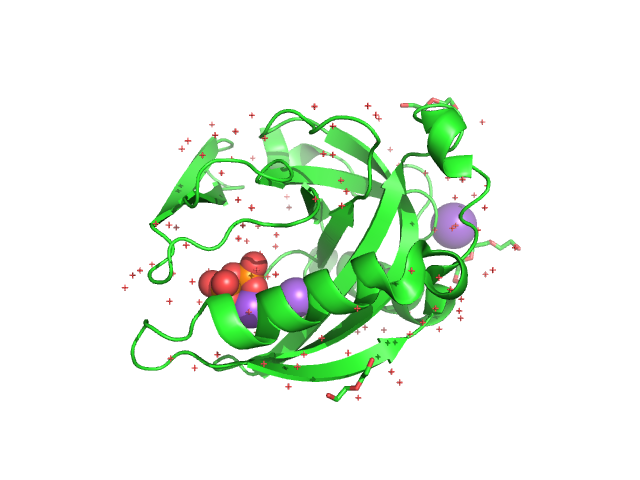

In [4]:
from graphein.utils.pymol import MolViewer

pymol = MolViewer()
pymol.delete("all") # eliminar todos los objetos de otras sesiones si es necesario
pymol.fetch("3eiy")
pymol.display()

### 1.1 Grafo de residuos

#### Configuración

`Graphein` está diseñado para procesar conjuntos de datos de estructuras de proteínas en grafos. Para ello, se utiliza una configuración global `ProteinGraphConfig` dónde:
* `granularity`: especifica la granularidad del grafo, es decir, qué representan los nodos.
Los valores posibles son:
  * Identificadores de átomo: p. ej., "CA" para α-carbono.
  * "centroid": para utilizar centroides de residuo, se utiliza la media de las coordenadas $x, y, z$ de los átomos del residuo.
  * "atom": para la construcción a nivel de átomo.
* `keep_hets`: booleano que especifica si mantener o no los heteroátomos (átomos no proteicos) presentes en el archivo .pdb.
* `insertions`: booleano que especifica si se conservan o no las inserciones (adición de uno o más nucleótidos en un segmento de ADN) en el archivo .pdb.
* `deprotonate`: booleano que indica si se eliminan o no los átomos de hidrógeno.

In [5]:
from graphein.protein.config import ProteinGraphConfig

# Configuración del grafo
params_to_change = {"granularity": "centroids"}
config = ProteinGraphConfig(**params_to_change)
config.dict()

{'granularity': 'centroids',
 'keep_hets': [],
 'insertions': True,
 'alt_locs': 'max_occupancy',
 'pdb_dir': None,
 'verbose': False,
 'exclude_waters': True,
 'deprotonate': False,
 'protein_df_processing_functions': None,
 'edge_construction_functions': [<function graphein.protein.edges.distance.add_peptide_bonds(G: 'nx.Graph') -> 'nx.Graph'>],
 'node_metadata_functions': [<function graphein.protein.features.nodes.amino_acid.meiler_embedding(n: str, d: Dict[str, Any], return_array: bool = False) -> Union[pandas.core.series.Series, numpy.ndarray]>],
 'edge_metadata_functions': None,
 'graph_metadata_functions': None,
 'get_contacts_config': None,
 'dssp_config': None}

#### Lectura y preprocesamiento de datos

`Graphein` puede trabajar con datos a partir de:

*   Archivo .pdb: permite realizar el preprocesamiento que se desee.
*   Código de acceso pdb: devuelve una estructura de la propia PDB.

In [6]:
from graphein.protein.graphs import construct_graph
from graphein.protein.visualisation import plotly_protein_structure_graph

# Código pdb
g = construct_graph(config=config, pdb_code="3eiy")

# Archivo .pdb
g = construct_graph(config=config, path=input_path.format("3eiy.pdb"))

# Representación del grafo
p = plotly_protein_structure_graph(
    g,
    colour_edges_by="kind",
    colour_nodes_by="degree", # nodos coloreados por su grado
    label_node_ids=False,
    plot_title="Grafo de residuos con enlaces peptídicos",
    node_size_multiplier=1)

Output()

Output()

In [7]:
p.show()

También se puede construir un preprocesado desde cero a partir de un archivo .pdb.

Además, se pueden definir funciones propias para el preprocesado.

In [8]:
from graphein.protein.graphs import read_pdb_to_dataframe, process_dataframe, deprotonate_structure, convert_structure_to_centroids, remove_insertions

# Lectura del dataframe a partir de un código pdb
pdb_code = "3eiy"
raw_df = read_pdb_to_dataframe(pdb_code=pdb_code)

# Aplicación de funciones de preprocesamiento
processing_funcs = [deprotonate_structure, convert_structure_to_centroids, remove_insertions]
df = process_dataframe(raw_df, atom_df_processing_funcs=processing_funcs)
df.head()

record_name  atom_number atom_name alt_loc residue_name chain_id  \
0        ATOM            2        CA                  SER        A   
1        ATOM            8        CA                  PHE        A   
2        ATOM           19        CA                  SER        A   
3        ATOM           25        CA                  ASN        A   
4        ATOM           33        CA                  VAL        A   

   residue_number insertion   x_coord    y_coord   z_coord  occupancy  \
0               2            3.254333  54.615498 -0.136833        1.0   
1               3            3.206000  51.417271  2.656727        1.0   
2               4            4.649333  50.090836 -2.889667        1.0   
3               5            7.057500  52.758999 -4.146375        1.0   
4               6            9.549714  51.575432  0.109000        1.0   

    b_factor element_symbol charge  model_idx  node_id residue_id  
0  52.540001              C                 1  A:SER:2    A:SER:2  
1  48.730000              C                 1  A:PHE:3    A:PHE:3  
2  47.000000              C                 1  A:SER:4    A:SER:4  
3  41.419998              C                 1  A:ASN:5    A:ASN:5  
4  32.410000              C                 1  A:VAL:6    A:VAL:6

A continuación, se construye el grafo a partir de los datos anteriores como sigue.

In [9]:
from graphein.protein.graphs import initialise_graph_with_metadata, add_nodes_to_graph
from graphein.protein.edges.distance import add_peptide_bonds, add_hydrogen_bond_interactions
from graphein.protein.graphs import compute_edges

# Inicialización del grafo
g = initialise_graph_with_metadata(protein_df=df, # dataframe preprocesado
                                   raw_pdb_df=raw_df, # dataframe no preprocesado, para trazabilidad
                                   pdb_code=pdb_code,
                                   granularity="centroid" # nivel de la proteína
                                  )

# Añadir nodos
g = add_nodes_to_graph(g)

# Añadir aristas
g = compute_edges(g, funcs=[add_peptide_bonds, add_hydrogen_bond_interactions])

# Representación
p = plotly_protein_structure_graph(
    g,
    colour_edges_by="kind",
    colour_nodes_by="seq_position",
    label_node_ids=False,
    plot_title="Grafo de residuos a partir del preprocesado propio de los datos",
    node_size_multiplier=1)

In [10]:
p.show()

Ahora se va a preprocesar un conjunto de datos proveniente de AlphaFold Protein Structure Database.

Se va a estudiar At1g58602 (UnitProt Q8W3K0), una proteína de resistencia a enfermedades.

In [11]:
from graphein.protein.utils import download_alphafold_structure

# Descarga del archivo PDB correspondiente al UniProt Q8W3K0
protein_path = download_alphafold_structure("Q8W3K0", out_dir=path, aligned_score=False)

# Construcción del grafo
g = construct_graph(config=config, path=protein_path)

# Representación
p = plotly_protein_structure_graph(
    g,
    colour_edges_by="kind",
    colour_nodes_by="residue_name",
    label_node_ids=False,
    plot_title="Grafo de residuos con datos procedentes de AlphafoldDB",
    node_size_multiplier=0.5)

Output()

In [12]:
p.show()

#### Construcción de aristas

Se pueden añadir aristas entre dos nodos del grafo dependiendo del tipo de enlace entre sus moléculas respectivas:

* Enlace peptídico: unión de dos aminoácidos mediante la pérdida de una molécula de agua entre el grupo amino de un aminoácido y el grupo carboxilo del otro.
* Enlace de hidrógeno: se forma entre átomos de oxígeno esqueletales y átomos de hidrógeno amida.
* Enlace disulfuro.
* Enlace iónico.
* Enlace aromático: interacción con aminoácidos aromáticos.
* Enlace catión-π: interacción molecular no covalente entre la cara de un sistema π rico en electrones con un catión adyacente.



In [13]:
from graphein.protein.edges.distance import (add_peptide_bonds,
                                             add_hydrogen_bond_interactions,
                                             add_disulfide_interactions,
                                             add_ionic_interactions,
                                             add_aromatic_interactions,
                                             add_aromatic_sulphur_interactions,
                                             add_cation_pi_interactions
                                            )

# Configuración del grafo
new_edge_funcs = {"edge_construction_functions": [add_peptide_bonds,
                                                  add_aromatic_interactions,
                                                  add_hydrogen_bond_interactions,
                                                  add_disulfide_interactions,
                                                  add_ionic_interactions,
                                                  add_aromatic_sulphur_interactions,
                                                  add_cation_pi_interactions]}

config = ProteinGraphConfig(**new_edge_funcs)

# Construcción del grafo
g_link = construct_graph(config=config, pdb_code="3eiy")

# Representación
p = plotly_protein_structure_graph(
    g_link,
    colour_edges_by="kind",
    colour_nodes_by="seq_position",
    label_node_ids=False,
    plot_title="Grafo de residuos con diferentes tipos de enlaces",
    node_size_multiplier=1)

Output()

In [14]:
p.show()

También se pueden añadir aristas basadas en el cálculo de la distancia entre moléculas:

* Triangulación Delaunay: añade aristas de forma que se verifique la condición de Delaunay, es decir, que la circunferencia circunscrita de cada triángulo no debe contener ningún otro vértice de la triangulación en su interior.
* KNN: añade aristas basadas en los $k$ vecinos más cercanos.
* Distancia de corte.

In [15]:
from graphein.protein.edges.distance import add_delaunay_triangulation

# Configuración del grafo
new_edge_funcs = {"edge_construction_functions": [add_delaunay_triangulation]}
config = ProteinGraphConfig(**new_edge_funcs)

# Construcción del grafo
g = construct_graph(config=config, pdb_code="3eiy")

# Representación
p = plotly_protein_structure_graph(
    G=g,
    colour_edges_by="kind",
    colour_nodes_by="seq_position",
    label_node_ids=False,
    node_size_multiplier=1,
    plot_title="Grafo de residuos a partir de la triangulación Delaunay")

Output()

In [16]:
p.show()

In [17]:
from functools import partial
from graphein.protein.edges.distance import add_distance_threshold

# Configuración del grafo
new_edge_funcs = {"edge_construction_functions": [partial(add_distance_threshold, long_interaction_threshold=5, threshold=10.)]} # aristas entre nodos cuya distancia es más de 10 y con 5 posiciones de diferencia como mínimo
config = ProteinGraphConfig(**new_edge_funcs)

# Construcción del grafo
g = construct_graph(config=config, pdb_code="3eiy")

# Representación
p = plotly_protein_structure_graph(
    g,
    colour_edges_by="kind",
    colour_nodes_by="seq_position",
    label_node_ids=False,
    plot_title="Grafo de residuos a partir de la distancia de corte",
    node_size_multiplier=1)

Output()

In [18]:
p.show()

In [19]:
from functools import partial
from graphein.protein.edges.distance import add_k_nn_edges

# Configuración del grafo
new_edge_funcs = {"edge_construction_functions": [partial(add_k_nn_edges, k=3, long_interaction_threshold=0)]} # aristas basadas en los 3 vecinos más cercanos
config = ProteinGraphConfig(**new_edge_funcs)

# Construcción del grafo
g = construct_graph(config=config, pdb_code="3eiy")

# Representación
p = plotly_protein_structure_graph(
    g,
    colour_edges_by="kind",
    colour_nodes_by="seq_position",
    label_node_ids=False,
    plot_title="Grafo de residuos basado en KNN con k=3",
    node_size_multiplier=1)

Output()

In [20]:
p.show()

También se pueden definir funciones propias para la construcción de aristas.

#### Características

`Graphein` está diseñado para facilitar el aprendizaje profundo geométrico de estructuras de proteínas, por lo que se tiene una gran variedad de funciones de anotación de características.

Existen tres niveles de anotación:
* Nivel de nodo.
* Nivel de arista.
* Nivel de grafo.

In [21]:
from graphein.protein.features.sequence.sequence import molecular_weight

# Configuración del grafo
new_graph_annotation_funcs = {"graph_metadata_functions": [molecular_weight]} # anotación a nivel de grafo
config = ProteinGraphConfig(**new_graph_annotation_funcs)

# Construcción del grafo
g = construct_graph(config=config, pdb_code="3eiy")

print("Secuencia A:", g.graph["sequence_A"])
print("Peso molecular de la secuencia A:", g.graph["molecular_weight_A"]) # peso de 1 mol o N (número de Avogadro) número de moléculas de la proteína

Output()

Secuencia A: SFSNVPAGKDLPQDFNVIIEIPAQSEPVKYEADKALGLLVVDRFIGTGMRYPVNYGFIPQTLSGDGDPVDVLVITPFPLLAGSVVRARALGMLKMTDESGVDAKLVAVPHDKVCPMTANLKSIDDVPAYLKDQIKHFFEQYKALEKGKWVKVEGWDGIDAAHKEITDGVANFKK
Peso molecular de la secuencia A: 19029.71029999999


In [22]:
from graphein.protein.features.nodes.amino_acid import expasy_protein_scale

# Configuración del grafo
config = ProteinGraphConfig(**{"node_metadata_functions": [expasy_protein_scale]}) # anotación a nivel de nodo

# Construcción del grafo
g = construct_graph(config=config, pdb_code="3eiy")

for n, d in g.nodes(data=True):
    print(d["expasy"]) # representa el perfil producido por cualquier escala de aminoácidos en una proteína seleccionada
    break

Output()

pka_cooh_alpha               2.21
pka_nh3                      9.15
pka_rgroup                   7.00
isoelectric_points           5.68
molecularweight            105.00
                            ...  
antiparallelbeta_strand      0.87
parallelbeta_strand          0.70
a_a_composition              6.90
a_a_swiss_prot               6.56
relativemutability         120.00
Name: SER, Length: 61, dtype: float64


Al igual que en el apartado anterior, también se pueden definir funciones propias para obtener características y metadatos de los diferentes elementos del grafo.

#### Análisis

`Graphein` permite realizar diversos análisis sobre la estructura de los grafos y las propiedades fisicoquímicas.

Se va a analizar el grafo "Grafo de residuos con diferentes tipos de enlaces".

En primer lugar, se va a mostrar la composición de residuos del grafo.
Esta librería permite mostrarlo a través de un diagrama de barras o un gráfico circular.

In [23]:
from graphein.protein.analysis import plot_residue_composition

fig = plot_residue_composition(g_link, sort_by="count", plot_type="bar")
fig.update_traces(marker=dict(color="blue"), showlegend=False)
fig.layout["title"]["text"] = "3eiy - Composición de los residuos"
fig.layout["xaxis"]["title"]["text"] = "Residuo"
fig.layout["yaxis"]["title"]["text"] = "Frecuencia"
fig.show()

También se puede representar gráficamente la distribución de los grados de los nodos en el grafo de proteínas.

In [24]:
from graphein.protein.analysis import plot_degree_distribution

fig = plot_degree_distribution(g_link)
fig.update_traces(marker=dict(color="green"))
fig.layout["title"]["text"] = "3eiy - Distribución de los grados de los nodos"
fig.layout["xaxis"]["title"]["text"] = "Grado"
fig.layout["yaxis"]["title"]["text"] = "Frecuencia"
fig.show()

Además, se puede obtener la distribución de los tipos de aristas en el grafo.

In [25]:
from graphein.protein.analysis import plot_edge_type_distribution

fig = plot_edge_type_distribution(g_link, plot_type="bar", title="3ey - Distribución de los tipos de enlaces")
fig.update_traces(marker=dict(color="darkorange"), showlegend=False)
fig.layout["xaxis"]["title"]["text"] = "Enlace"
fig.layout["yaxis"]["title"]["text"] = "Frecuencia"
fig.show()

### 1.2 Grafo atómico

#### Configuración

Se va a utilizar la misma configuración que en el apartado anterior excepto que `granularity` va a tomar el valor "atoms" y se va a utilizar una función específica en la construcción de aristas.

In [26]:
from graphein.protein.edges.atomic import add_atomic_edges

# Configuración del grafo
params_to_change = {"granularity": "atom", "edge_construction_functions": [add_atomic_edges]}
config = ProteinGraphConfig(**params_to_change)
config.dict()

{'granularity': 'atom',
 'keep_hets': [],
 'insertions': True,
 'alt_locs': 'max_occupancy',
 'pdb_dir': None,
 'verbose': False,
 'exclude_waters': True,
 'deprotonate': False,
 'protein_df_processing_functions': None,
 'edge_construction_functions': [<function graphein.protein.edges.atomic.add_atomic_edges(G: networkx.classes.graph.Graph, tolerance: float = 0.56) -> networkx.classes.graph.Graph>],
 'node_metadata_functions': [<function graphein.protein.features.nodes.amino_acid.meiler_embedding(n: str, d: Dict[str, Any], return_array: bool = False) -> Union[pandas.core.series.Series, numpy.ndarray]>],
 'edge_metadata_functions': None,
 'graph_metadata_functions': None,
 'get_contacts_config': None,
 'dssp_config': None}

#### Lectura y preprocesamiento de datos

Al igual que en el apartado anterior, `Graphein` puede trabajar con datos a partir de:

*   Archivo .pdb: permite realizar el preprocesamiento que se desee.
*   Código de acceso pdb: devuelve una estructura de la propia PDB.

In [27]:
# Código pdb
g = construct_graph(config=config, pdb_code="3eiy")

# Archivo .pdb
g = construct_graph(config=config, path=input_path.format("3eiy.pdb"))

# Representación del grafo
p = plotly_protein_structure_graph(
    g,
    colour_edges_by="kind",
    colour_nodes_by="element_symbol",
    label_node_ids=False,
    node_size_min=5,
    node_alpha=0.85,
    node_size_multiplier=1,
    plot_title="Grafo atómico con enlaces covalentes")

Output()

Output()

In [28]:
p.show()

#### Construcción de aristas

Como se puede ver, todos los tipos de enlace son iguales.
Se puede saber qué tipo de enlace covalente es el que se muestra: simple, doble, triple, etc.

In [29]:
from graphein.protein.edges.atomic import add_bond_order

# Configuración del grafo
params_to_change = {"granularity": "atom", "edge_construction_functions": [add_atomic_edges, add_bond_order]}
config = ProteinGraphConfig(**params_to_change)

# Construcción del grafo
g = construct_graph(config=config, pdb_code="3eiy")

p = plotly_protein_structure_graph(
    g,
    colour_edges_by="kind",
    colour_nodes_by="element_symbol",
    label_node_ids=False,
    node_size_min=5,
    node_alpha=0.85,
    node_size_multiplier=1,
    plot_title="Grafo atómico con distintos tipos de enlaces covalentes")

Output()

In [30]:
p.show()

Al igual que en el apartado anterior, también se pueden añadir aristas basadas en el cálculo de la distancia entre átomos.

Se va a mostrar un ejemplo utilizando la triangulación Delaunay.

In [31]:
from functools import partial
from graphein.protein.edges.distance import add_delaunay_triangulation

# Configuración del grafo
params_to_change = {"granularity": "atom", "edge_construction_functions": [add_atomic_edges, add_bond_order, partial(add_delaunay_triangulation)]}
config = ProteinGraphConfig(**params_to_change)

# Construcción del grafo
g = construct_graph(config=config, pdb_code="3eiy")

# Representación
p = plotly_protein_structure_graph(
    g,
    colour_edges_by="kind",
    colour_nodes_by="element_symbol",
    label_node_ids=False,
    node_size_min=5,
    node_alpha=0.85,
    node_size_multiplier=1,
    plot_title="Grafo atómico a partir de la triangulación Delaunay")

Output()

In [32]:
p.show()

## 2. Molécula

Es un grupo eléctricamente neutro y suficientemente estable de al menos dos átomos unidos por enlaces químicos fuertes covalentes.

`Graphein` proporciona un conjunto de herramientas para trabajar con grafos moleculares. Además, incluye funciones *RDKit* (conjunto de herramientas de código abierto para quimioinformática) para la construcción de grafos.

### Configuración

Al igual que en las proteínas, también se utiliza una configuración global.

In [33]:
import graphein.molecule as gm

# Configuración del grafo
config = gm.MoleculeGraphConfig()
config

Creating directory /root/.config/bioservices 


MoleculeGraphConfig(verbose=False, add_hs=False, generate_conformer=False, edge_construction_functions=[<function add_fully_connected_edges at 0x7d0744c03f40>, <function add_k_nn_edges at 0x7d0744cc0040>, <function add_distance_threshold at 0x7d0744c03eb0>, <function add_atom_bonds at 0x7d0744c03a30>], node_metadata_functions=[<function atom_type_one_hot at 0x7d073a3be7a0>], edge_metadata_functions=None, graph_metadata_functions=None)

### Lectura y preprocesamiento de datos

Se pueden construir grafos de moléculas a partir de:
* *Simplified Molecular Input Line Entry System* (sistema de introducción lineal molecular simplificada o SMILES): especificación para describir sin ambigüedades la estructura de una molécula usando cadenas ASCII cortas.
* Fichero .sdf: proporciona coordenadas.
* Fichero .mol2: proporciona coordenadas.

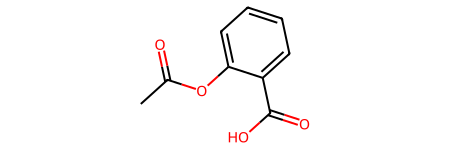

In [34]:
# Especificación smiles
graph = gm.construct_graph(smiles="CC(=O)OC1=CC=CC=C1C(=O)O", config=config) # ácido acetilsalicílico (aspirina)
graph.graph["rdmol"]

In [35]:
# Archivo .mol2
graph = gm.construct_graph(path=input_path.format("short_test.mol2"), config=config)

# Archivo .sdf
graph = gm.construct_graph(path=input_path.format("long_test.sdf"), config=config)

# Representación
print(graph.graph['smiles'])
gm.plotly_molecular_graph(graph)

N#C[C@H](O[C@H](C=CC=O)n1cccc1)c1ccccc1


### Características

`Graphein` puede añadir características mediante el uso de RDKit.

Existen tres niveles de anotación:
* Nivel de nodo: masa, valencia, número de electrones, si es isótopo o no, etc.
* Nivel de arista: tipo de enlace (covalente, iónico).
* Nivel de grafo: descriptores globales de la molécula calculados por RDKit.

In [36]:
from functools import partial

# Configuración del grafo
config = gm.MoleculeGraphConfig(
    node_metadata_functions=[ # características a nivel de nodo
        gm.atom_type_one_hot,
        gm.atomic_mass,
        gm.degree,
        gm.total_degree,
        gm.total_valence,
        gm.explicit_valence,
        gm.implicit_valence,
        gm.num_explicit_h,
        gm.num_implicit_h,
        gm.total_num_h,
        gm.num_radical_electrons,
        gm.formal_charge,
        gm.hybridization,
        gm.is_aromatic,
        gm.is_isotope,
        gm.is_ring,
        gm.chiral_tag,
        partial(gm.is_ring_size, ring_size=5),
        partial(gm.is_ring_size, ring_size=7)
    ])

# Construcción del grafo
graph = gm.construct_graph(path=input_path.format("short_test.mol2"), config=config)

for n, d in graph.nodes(data=True):
    print(d)

{'atomic_num': 6, 'element': 'C', 'rdmol_atom': <rdkit.Chem.rdchem.Atom object at 0x7d073a3afc30>, 'coords': array([ 0.9862, -0.257 , -0.1905]), 'atom_type_one_hot': array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'mass': 12.011, 'degree': 1, 'total_degree': 4, 'total_valence': 4, 'explicit_valence': 4, 'implicit_valence': 0, 'num_explicit_h': 3, 'num_implicit_h': 0, 'total_num_h': 3, 'num_radical_electrons': 0, 'formal_charge': 0, 'hybridization': rdkit.Chem.rdchem.HybridizationType.SP3, 'is_aromatic': False, 'is_isotope': 0, 'is_ring': False, 'chiral_tag': rdkit.Chem.rdchem.ChiralType.CHI_UNSPECIFIED, 'is_ring_5': False, 'is_ring_7': False}
{'atomic_num': 6, 'element': 'C', 'rdmol_atom': <rdkit.Chem.rdchem.Atom object at 0x7d073a3afca0>, 'coords': array([-0.2052,  0.2236,  0.6206]), 'atom_type_one_hot': array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'mass': 12.011, 'degree': 2, 'total_degree': 4, 'total_valence': 4, 'explicit_valence': 4, 'implicit_valence': 0, 'num_explicit_h': 2, 'num_implici

In [37]:
# Configuración del grafo
config = gm.MoleculeGraphConfig(
    edge_metadata_functions=[ # características a nivel de arista
        gm.add_bond_type,
        gm.bond_is_aromatic,
        gm.bond_is_conjugated,
        gm.bond_is_in_ring,
        gm.bond_stereo,
        partial(gm.bond_is_in_ring_size, ring_size=5),
        partial(gm.bond_is_in_ring_size, ring_size=7)
    ])

# Construcción del grafo
graph = gm.construct_graph(path=input_path.format("short_test.mol2"), config=config)

for u, v, d in graph.edges(data=True):
    print(d)

{'kind': {'fully_connected', 'distance_threshold'}, 'bond_type': None, 'aromatic': None, 'conjugated': None, 'ring': None, 'bond_stereo': None, 'ring_size_5': None, 'ring_size_7': None}
{'kind': {'bond', 'k_nn_1', 'fully_connected', 'distance_threshold'}, 'bond': <rdkit.Chem.rdchem.Bond object at 0x7d0739724a50>, 'bond_type': rdkit.Chem.rdchem.BondType.SINGLE, '_aromatic': False, 'conjugated': False, 'ring': False, 'bond_stereo': rdkit.Chem.rdchem.BondStereo.STEREONONE, 'ring_size_5': False, 'ring_size_7': False}
{'kind': {'fully_connected', 'distance_threshold'}, 'bond_type': None, 'aromatic': None, 'conjugated': None, 'ring': None, 'bond_stereo': None, 'ring_size_5': None, 'ring_size_7': None}
{'kind': {'fully_connected', 'distance_threshold'}, 'bond_type': None, 'aromatic': None, 'conjugated': None, 'ring': None, 'bond_stereo': None, 'ring_size_5': None, 'ring_size_7': None}
{'kind': {'bond', 'k_nn_1', 'fully_connected', 'distance_threshold'}, 'bond': <rdkit.Chem.rdchem.Bond object 

In [38]:
# Configuración del grafo
config = gm.MoleculeGraphConfig(
    graph_metadata_functions=[ # características a nivel de grafo
        gm.mol_descriptors
    ])

# Construcción del grafo
graph = gm.construct_graph(path=input_path.format("short_test.mol2"), config=config)

print(graph.graph)

{'name': 'short_test', 'rdmol': <rdkit.Chem.rdchem.Mol object at 0x7d0739724d60>, 'coords': array([[ 0.9862, -0.257 , -0.1905],
       [-0.2052,  0.2236,  0.6206],
       [-1.4201,  0.2357, -0.1847]]), 'smiles': 'CCN', 'config': MoleculeGraphConfig(verbose=False, add_hs=False, generate_conformer=False, edge_construction_functions=[<function add_fully_connected_edges at 0x7d0744c03f40>, <function add_k_nn_edges at 0x7d0744cc0040>, <function add_distance_threshold at 0x7d0744c03eb0>, <function add_atom_bonds at 0x7d0744c03a30>], node_metadata_functions=[<function atom_type_one_hot at 0x7d073a3be7a0>], edge_metadata_functions=None, graph_metadata_functions=[<function mol_descriptors at 0x7d0744cc0940>]), 'MaxAbsEStateIndex': 4.847222222222222, 'MaxEStateIndex': 4.847222222222222, 'MinAbsEStateIndex': 0.75, 'MinEStateIndex': 0.75, 'qed': 0.40623709538988323, 'SPS': 6.0, 'MolWt': 45.084999999999994, 'HeavyAtomMolWt': 38.028999999999996, 'ExactMolWt': 45.057849223999995, 'NumValenceElectrons

[00:45:31] DEPRECATION WARNING: please use MorganGenerator
[00:45:31] DEPRECATION WARNING: please use MorganGenerator
[00:45:31] DEPRECATION WARNING: please use MorganGenerator


## 3. ARN

Es un polinucleótido formado por una cadena simple de ribonucleótidos. Cada uno de éstos se compone de una ribosa, un fosfato y una de las cuatro bases nitrogenadas (adenina, guanina, citosina y uracilo).

En esta sección, se van a construir grafos de la estructura secundaria del ARN.

Para ello, se requiere:
* Estructura primaria (opcional): secuencia lineal de nucleótidos en la molécula de ARN.
* Estructura secundaria: detallada mediante la notación de puntos y paréntesis.

El flujo de trabajo que se sigue es similar al de los otros tipos de estructuras.

Se pueden añadir aristas entre dos nodos del grafo dependiendo del tipo de enlace entre sus átomos respectivos:
* Pares de bases.
* Pseudonudos.
* Fosfodiéster.

In [39]:
from graphein.rna.edges import (add_pseudoknots, add_phosphodiester_bonds, add_base_pairing_interactions)
from graphein.rna.graphs import construct_rna_graph_2d
from graphein.rna.visualisation import plot_rna_graph
from typing import List, Callable
import networkx as nx

# Construcción del grafo
edge_funcs: List[Callable] = [add_base_pairing_interactions, add_phosphodiester_bonds, add_pseudoknots] # construcción de aristas
g = construct_rna_graph_2d(
    sequence="CGUCUUAAACUCAUCACCGUGUGGAGCUGCGACCCUUCCCUAGAUUCGAAGACGAG",
    dotbracket="((((((...(((..(((...))))))...(((..((.....))..)))))))))..",
    edge_construction_funcs=edge_funcs)

# Representación
plot_rna_graph(g, layout=nx.layout.spring_layout)

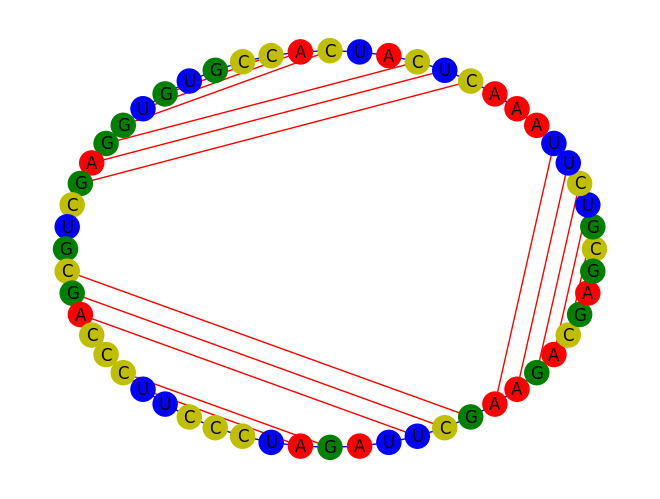

In [40]:
# Construcción del grafo
g = construct_rna_graph_2d(
    sequence="CGUCUUAAACUCAUCACCGUGUGGAGCUGCGACCCUUCCCUAGAUUCGAAGACGAG",
    dotbracket="((((((...(((..(((...))))))...(((..((.....))..)))))))))..",
    edge_construction_funcs=edge_funcs)

# Representación
plot_rna_graph(g, layout=nx.layout.circular_layout)

## 4. Interacción proteína-proteína (PPI)

Cualquier proteína que ejerce cualquier tipo de acción, efecto o influencia sobre otra, interactúa con dicha proteína. Sin embargo, en el campo de las ciencias de la vida, el término interacción proteína-proteína (PPI) se utiliza de una manera más específica:
* Tiene que implicar contacto físico directo, normalmente en una posición y orientación específicas (acoplamiento molecular), y formar un complejo proteico, permanente o transitorio.
* Tiene que ser no aleatorio, excluyendo así todas las proteínas que pueden chocar entre sí por casualidad.
* No debe ser genérico, sino servir para un propósito específico que difiera de funciones completamente genéricas, como la producción y degradación de proteínas.

**Contexto**:
la mayoría de los procesos celulares son realizados por proteínas. Para realizar su función, las proteínas necesitan interactuar con otras moléculas, muy frecuentemente otras proteínas. Para comprender cualquier proceso celular, es fundamental saber qué proteínas están involucradas, qué proteínas interactúan entre sí y cómo se regulan esas interacciones. Por consiguiente, las interacciones proteína-proteína son un tema importante en muchas áreas de investigación, desde la investigación básica hasta el desarrollo de fármacos.

**Banco de datos**:
* *STRING*: contiene alrededor de 5 millones de proteínas de 1133 organismos, con más de 100 millones de interacciones reportadas.
* *BioGRID*: repositorio de interacciones biomédicas con datos recopilados a través de exhaustivos esfuerzos de curación.

La librería `Graphein` facilita el estudio de estas estructuras permitiendo así el desarrollo de métodos de aprendizaje profundo geométrico para la interactómica estructural.

El flujo de trabajo que se sigue es similar al de los otros tipos de estructuras.

Se pueden añadir aristas entre dos nodos del grafo dependiendo de la base de datos de donde proceda:
* STRING.
* BioGRID.

In [41]:
from graphein.ppi.config import PPIGraphConfig
from graphein.ppi.graphs import compute_ppi_graph
from graphein.ppi.edges import add_string_edges, add_biogrid_edges
from graphein.ppi.visualisation import plotly_ppi_graph

# Configuración del grafo (tiene configuración para STRING y BioGRID)
config = PPIGraphConfig()

# Construcción del grafo
protein_list = ["CDC42", "CDK1", "KIF23", "PLK1", "RAC2", "RACGAP1", "RHOA", "RHOB"] # lista de proteínas
edge_construction_funcs = [add_string_edges, add_biogrid_edges] # construcción de aristas
g = compute_ppi_graph(config=config,
                      protein_list=protein_list,
                      edge_construction_funcs=edge_construction_funcs)

# Representación
plotly_ppi_graph(g)


A continuación, se va a representar un grafo de interacciones proteína-proteína entre el SARS-CoV-2 (causante de la enfermedad respiratoria COVID-19) y el ser humano teniendo en cuenta la lista de proteínas humanas que proporciona el artículo Gordon et al. (2020) *A SARS-CoV-2-Human Protein-Protein Interaction Map Reveals Drug Targets and Potential Drug-Repurposing*. Dicho artículo, a partir del estudio de las interacciones, reveló fármacos para combatir dicho virus.

In [42]:
# Lista de proteínas
protein_list = ['AP3B1', 'BRD4', 'BRD2', 'CWC27', 'ZC3H18', 'SLC44A2', 'PMPCB',
       'YIF1A', 'ATP1B1', 'ACADM', 'ETFA', 'STOM', 'GGCX', 'ATP6V1A',
       'PSMD8', 'REEP5', 'PMPCA', 'ANO6', 'PITRM1', 'SLC30A9', 'FASTKD5',
       'SLC30A7', 'TUBGCP3', 'COQ8B', 'SAAL1', 'REEP6', 'INTS4',
       'SLC25A21', 'TUBGCP2', 'TARS2', 'RTN4', 'FAM8A1', 'AASS', 'AKAP8L',
       'AAR2', 'BZW2', 'RRP9', 'PABPC1', 'CSNK2A2', 'CSNK2B', 'G3BP1',
       'PABPC4', 'LARP1', 'FAM98A', 'SNIP1', 'UPF1', 'MOV10', 'G3BP2',
       'DDX21', 'RBM28', 'RPL36', 'GOLGA7', 'ZDHHC5', 'POLA1', 'PRIM1',
       'PRIM2', 'POLA2', 'COLGALT1', 'PKP2', 'AP2A2', 'GFER', 'ERGIC1',
       'AP2M1', 'GRPEL1', 'TBCA', 'SBNO1', 'BCKDK', 'AKAP8', 'MYCBP2',
       'SLU7', 'RIPK1', 'UBAP2L', 'TYSND1', 'PDZD11', 'PRRC2B', 'UBAP2',
       'ZNF318', 'CRTC3', 'USP54', 'ZC3H7A', 'LARP4B', 'RBM41', 'TCF12',
       'PPIL3', 'PLEKHA5', 'TBKBP1', 'CIT', 'HSBP1', 'PCNT', 'CEP43',
       'PRKAR2A', 'PRKACA', 'PRKAR2B', 'RDX', 'CENPF', 'TLE1', 'TLE3',
       'TLE5', 'GOLGA3', 'GOLGA2', 'GOLGB1', 'GRIPAP1', 'CEP350',
       'PDE4DIP', 'CEP135', 'CEP68', 'CNTRL', 'ERC1', 'GCC2', 'CLIP4',
       'NIN', 'CEP112', 'MIPOL1', 'USP13', 'GCC1', 'JAKMIP1', 'CDK5RAP2',
       'AKAP9', 'GORASP1', 'FYCO1', 'C1orf50', 'CEP250', 'TBK1', 'HOOK1',
       'NINL', 'GLA', 'IMPDH2', 'SIRT5', 'NUTF2', 'ARF6', 'RNF41',
       'SLC27A2', 'EIF4E2', 'POR', 'RAP1GDS1', 'WASHC4', 'FKBP15',
       'GIGYF2', 'IDE', 'TIMM10', 'ALG11', 'NUP210', 'TIMM29', 'DNAJC11',
       'TIMM10B', 'TIMM9', 'HDAC2', 'GPX1', 'TRMT1', 'ATP5MG', 'ATP6AP1',
       'SIGMAR1', 'ATP13A3', 'AGPS', 'CYB5B', 'ACSL3', 'CYB5R3', 'RALA',
       'COMT', 'RAB5C', 'RAB7A', 'RAB8A', 'RAB2A', 'RAB10', 'RAB14',
       'RHOA', 'RAB1A', 'GNB1', 'GNG5', 'LMAN2', 'MOGS', 'TOR1AIP1',
       'MTARC1', 'QSOX2', 'HS2ST1', 'NDUFAF2', 'SCCPDH', 'SCARB1',
       'NAT14', 'DCAKD', 'FAM162A', 'DNAJC19', 'SELENOS', 'PTGES2',
       'RAB18', 'MPHOSPH10', 'SRP72', 'ATE1', 'NSD2', 'SRP19', 'SRP54',
       'MRPS25', 'DDX10', 'LARP7', 'MEPCE', 'NGDN', 'EXOSC8', 'NARS2',
       'NOL10', 'CCDC86', 'SEPSECS', 'EXOSC5', 'EXOSC3', 'AATF', 'HECTD1',
       'MRPS2', 'MRPS5', 'EXOSC2', 'MRPS27', 'GTF2F2', 'FBN1', 'FBN2',
       'NUP214', 'NUP62', 'DCAF7', 'EIF4H', 'NUP54', 'MIB1', 'SPART',
       'NEK9', 'ZNF503', 'NUP88', 'NUP58', 'MAT2B', 'FBLN5', 'PPT1',
       'CUL2', 'MAP7D1', 'THTPA', 'ZYG11B', 'TIMM8B', 'RBX1', 'ELOC',
       'ELOB', 'HMOX1', 'TRIM59', 'ARL6IP6', 'VPS39', 'CLCC1', 'VPS11',
       'SUN2', 'ALG5', 'STOML2', 'NUP98', 'RAE1', 'MTCH1', 'HEATR3',
       'MDN1', 'PLOD2', 'TOR1A', 'STC2', 'PLAT', 'ITGB1', 'CISD3',
       'COL6A1', 'PVR', 'DNMT1', 'LOX', 'PCSK6', 'INHBE', 'NPC2', 'MFGE8',
       'OS9', 'NPTX1', 'POGLUT2', 'POGLUT3', 'ERO1B', 'PLD3', 'FOXRED2',
       'CHPF', 'PUSL1', 'EMC1', 'GGH', 'ERLEC1', 'IL17RA', 'NGLY1',
       'HS6ST2', 'SDF2', 'NEU1', 'GDF15', 'TM2D3', 'ERP44', 'EDEM3',
       'SIL1', 'POFUT1', 'SMOC1', 'PLEKHF2', 'FBXL12', 'UGGT2', 'CHPF2',
       'ADAMTS1', 'HYOU1', 'FKBP7', 'ADAM9', 'FKBP10', 'SLC9A3R1',
       'CHMP2A', 'CSDE1', 'TOMM70', 'MARK3', 'MARK2', 'DPH5', 'DCTPP1',
       'MARK1', 'PTBP2', 'BAG5', 'UBXN8', 'GPAA1', 'WFS1', 'ABCC1',
       'F2RL1', 'SCAP', 'DPY19L1', 'TMEM97', 'SLC30A6', 'TAPT1', 'ERMP1',
       'NLRX1', 'RETREG3', 'PIGO', 'FAR2', 'ECSIT', 'ALG8', 'TMEM39B',
       'GHITM', 'ACAD9', 'NDFIP2', 'BCS1L', 'NDUFAF1', 'TMED5', 'NDUFB9',
       'PIGS']

In [43]:
# Configuración del grafo
config = PPIGraphConfig()

# Construcción del grafo
g = compute_ppi_graph(config=config, protein_list=protein_list, edge_construction_funcs=edge_construction_funcs)

# Representación
plotly_ppi_graph(g, node_size_multiplier=1, width=1000, height=1000, layout=nx.layout.circular_layout, edge_opacity=0.2)

En los dos grafos anteriores:
* Color de los nodos: depende del grado.
* Tamaño de los nodos: depende del grado.
* Color de las aristas:
  * Rojo: si procede de STRING.
  * Azul: si procede de BioGRID.
  * Amarillo: si procede de ambas.

Por otro lado, al igual que en módulos anteriores, se pueden añadir características a los nodos, aristas y grafos de la misma forma.